In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading the data

In [2]:
# TODO: how do we want to incorporate the functions from these files?
from data_utils import get_images, get_labels

The following is the list of disasters in our dataset. 

In [3]:
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]

We will load each disaster train dataset into a dictionary. Each disaster consists of images and labels (0 - 3) of the damage label.

In [4]:
data = {}
split = "train"
with open('config.json') as config_file:
    config = json.load(config_file)
    data_dir = config['data_dir']

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

Loading train images and labels for hurricane-matthew dataset...
Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


Visualizing an image and its label in the dataset. 

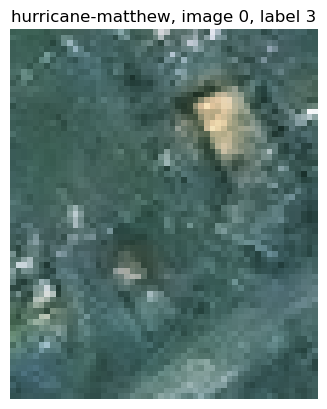

image shape: (65, 54, 3)


In [5]:
disaster = disaster_list[0]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# index of the image to display
idx = 0
img = images[idx]
label = labels[idx]

plt.title(f"{disaster}, image {idx}, label {label}")
plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

print(f"image shape: {img.shape}")

# EDA - Basic Statistics

## Number of Images per Disaster Type


In [6]:
for disaster in disaster_list:
    images = data[disaster]["images"]
    print(f"The {disaster} dataset has {len(images)} images.")

The hurricane-matthew dataset has 11151 images.
The socal-fire dataset has 8380 images.
The midwest-flooding dataset has 7004 images.


## Distribution of Image Sizes in Each Dataset

In [7]:
# Create dataframe with image height, width, and number of pixels
# Damage Labels are in dataframe
data_list = []

for disaster_name, disaster_data in data.items():
    # If a specific disaster is provided, filter for it
    images = disaster_data["images"]  
    damage_labels = disaster_data["labels"]

    for img, damage_label in zip(images, damage_labels):  
        # Extract features
        features = {
            "height": img.shape[0],
            "width": img.shape[1],
            "size": img.shape[0] * img.shape[1],
            "damage_label": damage_label,
            "disaster": disaster_name
        }

        data_list.append(features)  # Append features to list

df_size = pd.DataFrame(data_list)

In [8]:
# Checking for invalid data
df_size.isna().sum()

height          0
width           0
size            0
damage_label    0
disaster        0
dtype: int64

In [9]:
# View a few rows from image size dataframe
df_size.head()

,height,width,size,damage_label,disaster
0,65,54,3510,3,hurricane-matthew
1,67,105,7035,0,hurricane-matthew
2,54,56,3024,1,hurricane-matthew
3,114,124,14136,0,hurricane-matthew
4,58,51,2958,2,hurricane-matthew


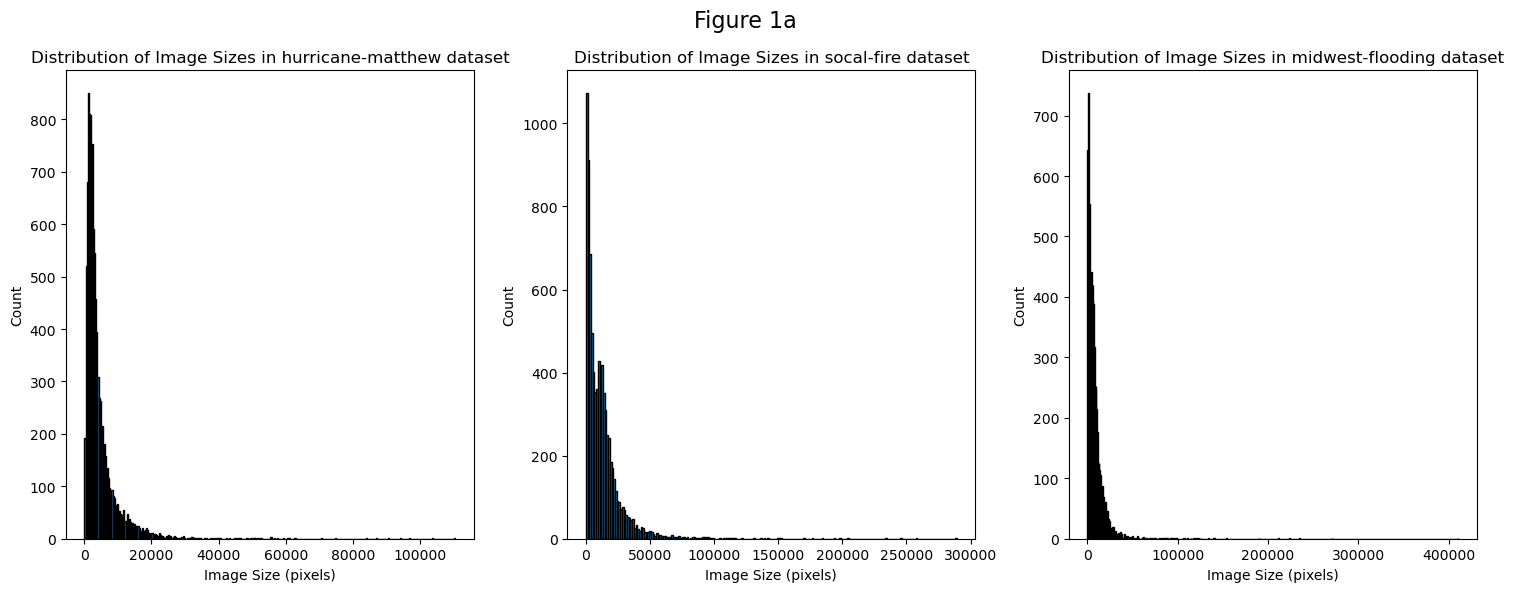

In [10]:
# Create a subplot for graphing
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot image size distributions for each disaster type
for i, disaster in enumerate(disaster_list):
    # Filter the DataFrame for the given disaster
    disaster_data = df_size[df_size['disaster'] == disaster]
    
    # Extract the image sizes
    size_array = disaster_data['size']
    
    # Plot histogram in the corresponding subplot
    axes[i].hist(size_array, bins='auto', edgecolor='black')
    axes[i].set_title(f"Distribution of Image Sizes in {disaster} dataset")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("Image Size (pixels)")

plt.suptitle("Figure 1a", fontsize=16)
plt.tight_layout()
plt.show()

## Distribution of Damage Labels

In [11]:
# Suppress Warnings
import warnings
warnings.simplefilter("ignore", FutureWarning)

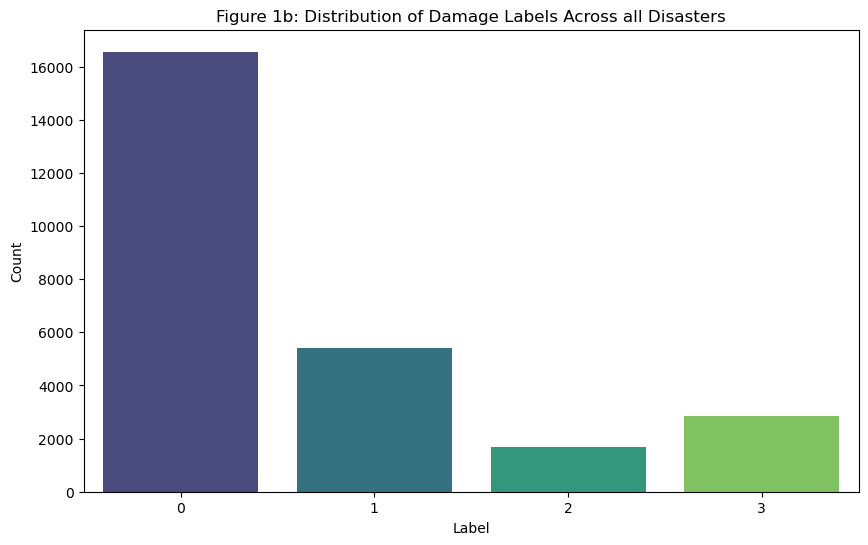

In [12]:
# Plot the histogram of labels in the dataset of all images
plt.figure(figsize=(10, 6))
sns.countplot(x='damage_label', data=df_size, palette="viridis")
plt.title("Figure 1b: Distribution of Damage Labels Across all Disasters")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

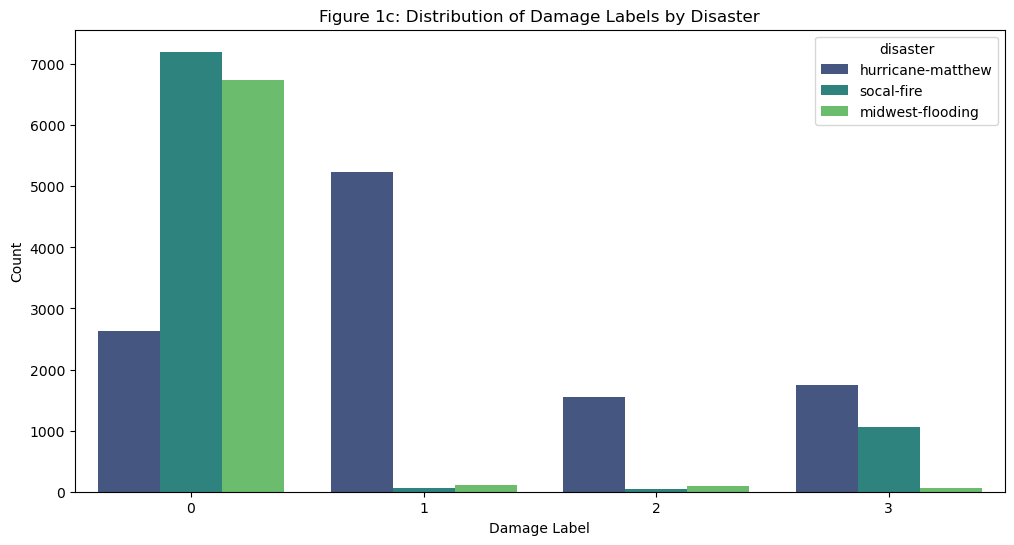

In [13]:
# Plot the histogram of labels by disaster type
plt.figure(figsize=(12, 6))
sns.countplot(x="damage_label", hue="disaster", data=df_size, palette="viridis")
plt.title("Figure 1c: Distribution of Damage Labels by Disaster")
plt.xlabel("Damage Label")
plt.ylabel("Count")
plt.show()

# EDA - Possible Distinguishing Features for Classification

### Distribution of Color (RGB)

In [14]:
def create_rgb_df(image_set, labels_set):
    """
    Creates a DataFrame with mean and standard deviation of RGB channels for each image in a set

    Parameters
    -----------
    image_set : list
                A list of images, where each image is represented as a NumPy array of shape (height, width, 3)

    Returns
    --------
    df : pd.DataFrame
        A DataFrame with columns containing the mean and standard deviation of the red, green, and blue channels, respectively
    """
    final_folder = []
    
    for idx, image in enumerate(image_set):
        # Extract label
        label = labels_set[idx]

        # Convert image to uint8 type for image processing
        image = image.astype(np.uint8)

        # Extract individual color channels
        red = np.array(image[:, :, 0])
        greens = np.array(image[:, :, 1])
        blues = np.array(image[:, :, 2])

        # Compute mean values for each of the color channels
        mean_r = np.mean(red)
        mean_g = np.mean(greens)
        mean_b = np.mean(blues)

        # Compute standard deviation for each of the color channels
        std_r = np.std(red)
        std_g = np.std(greens)
        std_b = np.std(blues)
        
        final_folder.append([label, mean_r, mean_g, mean_b, std_r, std_g, std_b])
    
    # Create dataframe with values
    df = pd.DataFrame(final_folder, columns=['damage_label', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b'])

    return df

In [15]:
fire_images = data["socal-fire"]["images"]
fire_labels = data["socal-fire"]["labels"]
rgb_fire_df = create_rgb_df(fire_images, fire_labels)
rgb_fire_df["Disaster"] = 0
rgb_fire_df = rgb_fire_df.drop(columns="damage_label")
rgb_fire_df.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,110.409046,131.513390,126.103811,51.128969,46.496437,51.925517,0
1,70.399918,89.844771,87.334559,22.793470,25.860936,34.624167,0
2,97.319162,122.642376,111.622184,42.198429,37.583086,42.969526,0
3,96.571841,113.395041,108.018512,32.584155,32.684069,37.025957,0
4,76.582532,103.573878,99.056731,26.867641,26.777957,36.632124,0


In [16]:
flooding_images = data["midwest-flooding"]["images"]
flooding_labels = data["midwest-flooding"]["labels"]
rgb_flooding_df = create_rgb_df(flooding_images, flooding_labels)
rgb_flooding_df["Disaster"] = 1
rgb_flooding_df = rgb_flooding_df.drop(columns="damage_label")
rgb_flooding_df.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,99.101461,119.192776,126.047484,26.461066,23.460615,26.590597,1
1,92.032590,111.545818,109.825624,30.047705,26.390695,32.643944,1
2,70.652585,95.393519,86.444637,17.645249,15.644754,22.724778,1
3,122.410779,140.645380,133.836051,48.386851,38.973870,43.524900,1
4,49.225397,82.200397,58.194444,26.080857,23.449150,23.616721,1


In [17]:
hurricane_images = data["hurricane-matthew"]["images"]
hurricane_labels = data["hurricane-matthew"]["labels"]
rgb_hurricane_df = create_rgb_df(hurricane_images, hurricane_labels)
rgb_hurricane_df["Disaster"] = 2
rgb_hurricane_df = rgb_hurricane_df.drop(columns="damage_label")
rgb_hurricane_df.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,75.702279,105.275783,101.084046,27.815519,23.648597,23.464383,2
1,88.451599,119.422886,110.248330,37.125076,33.972824,42.929292,2
2,111.971561,122.160714,119.043320,50.665334,44.679265,42.979921,2
3,96.979697,128.503962,127.725382,34.766489,27.807581,32.953153,2
4,87.179851,108.778905,96.311359,34.964564,32.776031,34.052103,2


In [18]:
df_rgb_all = pd.concat([rgb_flooding_df, rgb_fire_df, rgb_hurricane_df])
df_rgb_all.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,99.101461,119.192776,126.047484,26.461066,23.460615,26.590597,1
1,92.032590,111.545818,109.825624,30.047705,26.390695,32.643944,1
2,70.652585,95.393519,86.444637,17.645249,15.644754,22.724778,1
3,122.410779,140.645380,133.836051,48.386851,38.973870,43.524900,1
4,49.225397,82.200397,58.194444,26.080857,23.449150,23.616721,1


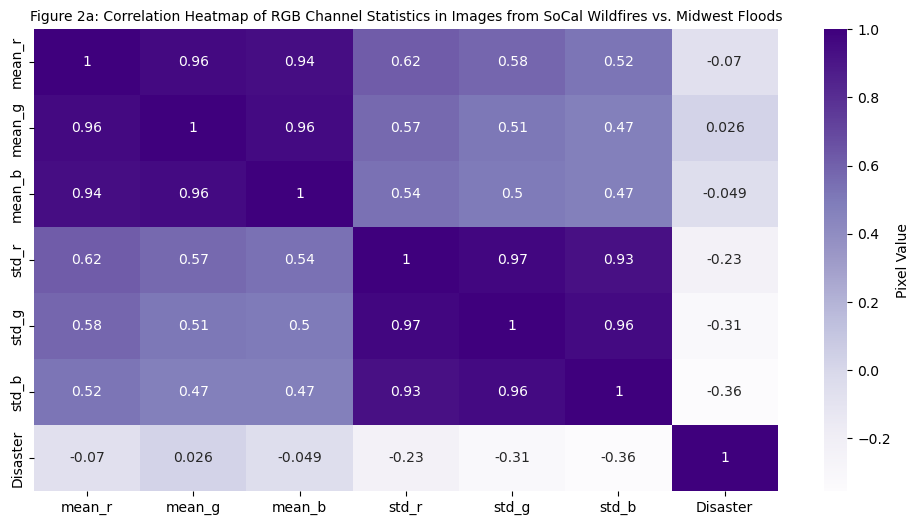

In [19]:
corr = df_rgb_all.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, cmap='Purples', annot=True, cbar_kws={'label': 'Pixel Value'})
plt.title(
    "Figure 2a: Correlation Heatmap of RGB Channel Statistics in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

In [20]:
def get_rgb_values(image_set):
    """
    Computes cumulative histograms and outputs the average for the red, green, and blue channels of all images in the provided image set.
    
    Parameters:
    -----------
    image_set : list
                A list of images, where each image is a NumPy array of shape (height, width, 3)

    Returns:
    --------
    mean_r_hist, mean_g_hist, mean_b_hist : numpy arrays
        The averaged histograms for the red, green, and blue channels for all images
    """
    r_hist_cum = []
    g_hist_cum = []
    b_hist_cum = []

    # Extract the individual color channels for each image
    for image in image_set:
        red = image[:, :, 0]
        greens = image[:, :, 1]
        blues = image[:, :, 2]

        # Compute histograms for each color and store in list
        r_histogram = np.histogram(red, bins=256, range=(0, 256))[0]
        r_hist_cum.append(r_histogram)
        g_histogram = np.histogram(greens, bins=256, range=(0, 256))[0]
        g_hist_cum.append(g_histogram)
        b_histogram = np.histogram(blues, bins=256, range=(0, 256))[0]
        b_hist_cum.append(b_histogram)
    
    # Calculate the mean value of each histogram
    mean_r_hist = np.mean(r_hist_cum, axis=0)
    mean_g_hist = np.mean(g_hist_cum, axis=0)
    mean_b_hist = np.mean(b_hist_cum, axis=0)
    return mean_r_hist, mean_g_hist, mean_b_hist

def plt_hist(mean_r_hist, mean_g_hist, mean_b_hist, disaster, figure_num):
    """
    Plots the RGB histograms for the given disaster dataset, based on the provided histograms

    Parameters:
    -----------
    mean_r_hist, mean_g_hist, mean_b_hist : numpy arrays
        The averaged histograms for the red, green, and blue channels
    
    disaster : str
        The name of the disaster dataset (for plot labeling)
    
    figure_num : int
        The figure number for the plot (for plot labeling)
    """
    plt.figure(figsize=(5, 5))

    plt.bar(range(256), mean_r_hist, color='red', alpha=0.5)

    plt.bar(range(256), mean_g_hist, color='green', alpha=0.5)

    plt.bar(range(256), mean_b_hist, color='blue', alpha=0.5)
    plt.title(f"Figure {figure_num}: RGB Histogram from {disaster} Images")
    plt.ylabel("Pixel Intensity")
    plt.xlabel("Pixel Count")


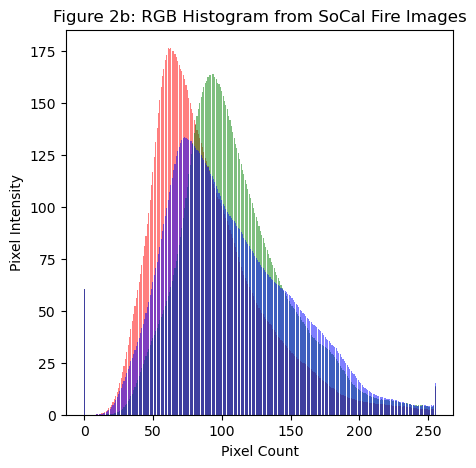

In [21]:
r, g, b = get_rgb_values(fire_images)
plt_hist(r, g, b, "SoCal Fire", "2b")

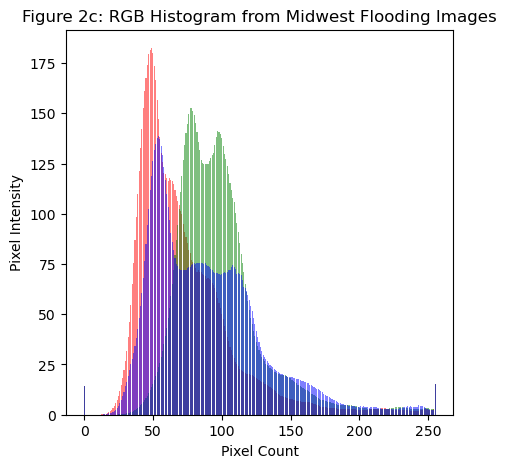

In [22]:
r, g, b = get_rgb_values(flooding_images)
plt_hist(r, g, b, "Midwest Flooding", "2c")

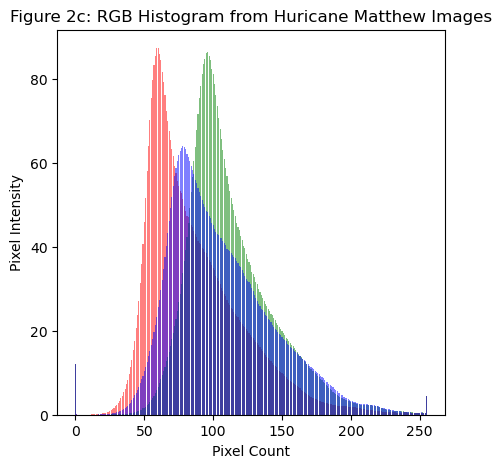

In [23]:
r, g, b = get_rgb_values(hurricane_images)
plt_hist(r, g, b, "Huricane Matthew", "2c")

#TODO: update below cell

Based on the above histograms it appears that there is a difference in distribution of RGB values for socal fire vs. midwest flooding.

### Image Size

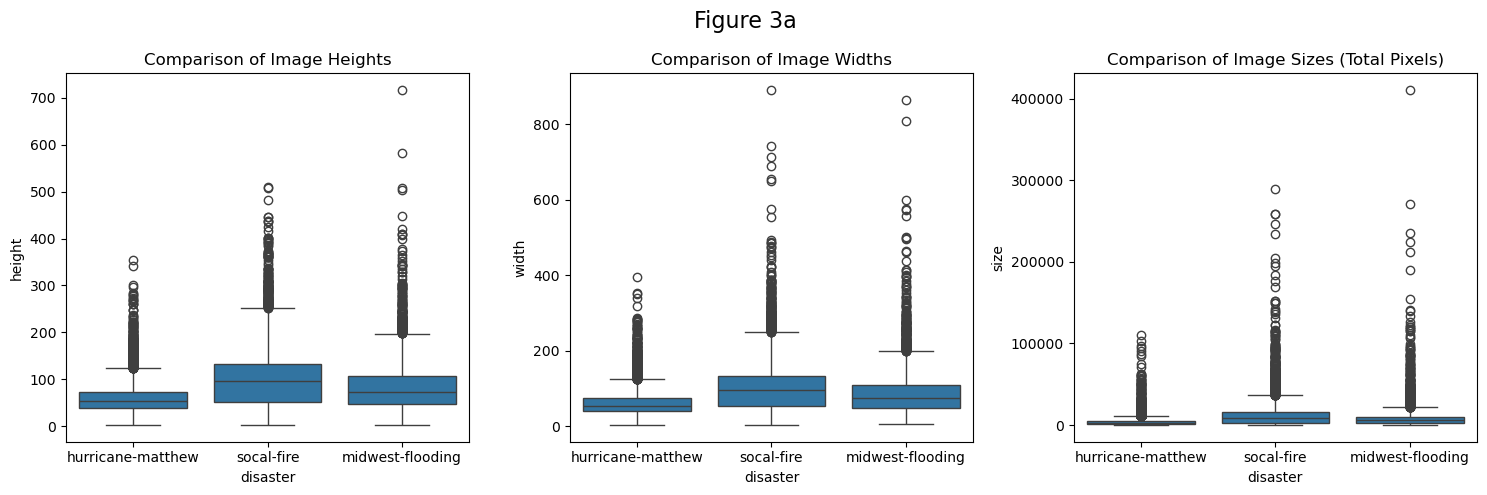

In [24]:
plt.figure(figsize=(15, 5))

# Height comparison
plt.subplot(1, 3, 1)
sns.boxplot(data=df_size, x="disaster", y="height")
plt.title("Comparison of Image Heights")

# Width comparison
plt.subplot(1, 3, 2)
sns.boxplot(data=df_size, x="disaster", y="width")
plt.title("Comparison of Image Widths")

# Size comparison
plt.subplot(1, 3, 3)
sns.boxplot(data=df_size, x="disaster", y="size")
plt.title("Comparison of Image Sizes (Total Pixels)")

plt.suptitle("Figure 3a", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# Convert the disaster column to a quantitative column
df_disaster_num = df_size.copy()
df_disaster_num["disaster_num"] = df_size["disaster"].map(lambda x: 1 if x == "socal-fire" else 
                                                          (2 if x == "hurricane-matthew" else 0))
df_disaster_num = df_disaster_num.drop(columns=["disaster", "damage_label"])
df_disaster_num.head()

,height,width,size,disaster_num
0,65,54,3510,2
1,67,105,7035,2
2,54,56,3024,2
3,114,124,14136,2
4,58,51,2958,2


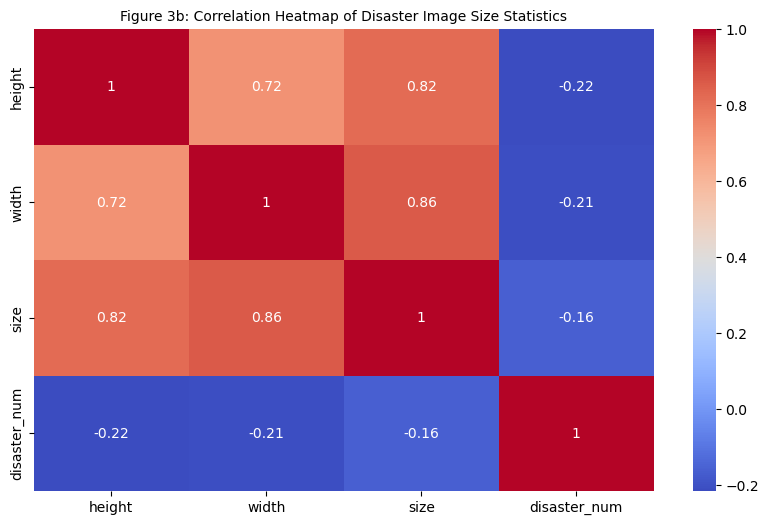

In [26]:
corr = df_disaster_num.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title(
    "Figure 3b: Correlation Heatmap of Disaster Image Size Statistics",
    fontsize = 10)
plt.show()

The disaster type does not seem to be correlated with the image size, height or width. 

# Damage Label Correlations

### Distribution of Color (RGB)

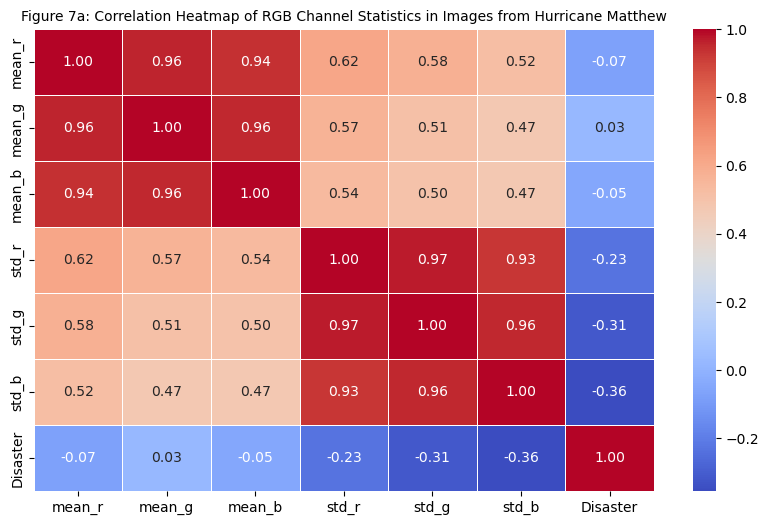

In [ ]:
rgb_correlation_matrix = df_rgb_all.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rgb_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 7a: Correlation Heatmap of RGB Channel Statistics in Disaster Images",
    fontsize = 10)
plt.show()

Based on the RGB correlation matrix above, there seems to be little correlation between RGB and damage label.

### Image Size

In [140]:
disaster_size_label_df = df_size[~df_size['damage_label'].isin([0, 2])] 
disaster_size_label_df = disaster_size_label_df[disaster_size_label_df['disaster'] == "hurricane-matthew"] 
disaster_size_label_df.drop(columns="disaster", inplace=True)
disaster_size_label_df.head()

,height,width,size,damage_label
0,65,54,3510,3
2,54,56,3024,1
5,43,43,1849,1
7,12,33,396,1
8,50,44,2200,1


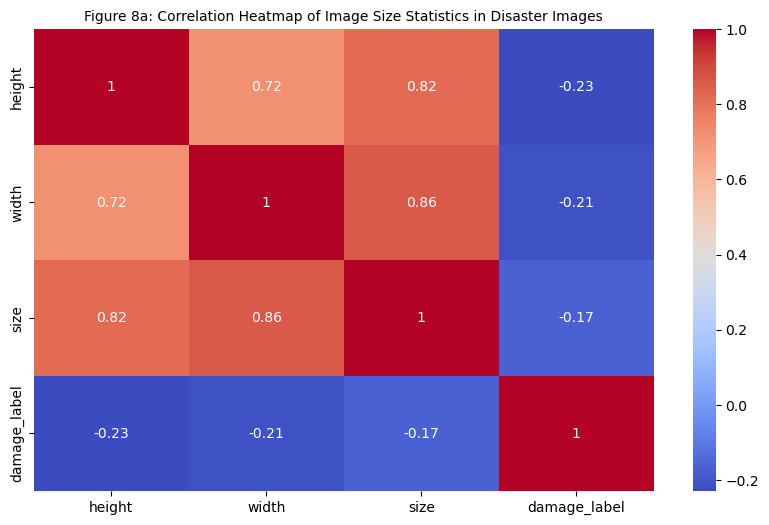

In [29]:
corr = df_size.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title(
    "Figure 8a: Correlation Heatmap of Image Size Statistics in Disaster Images",
    fontsize = 10)
plt.show()

In [31]:
# TODO: update explanation below; left off here

Based on the above analysis, it seems like height, width, total pixels, height^2 and perimeter all have correlations above >0.2 to damage label. The perimeter is most strongly correlated with damage labels out of all of the features we engineered.

### Sobel Edges

In [145]:
# Create a DataFrame with Sobel Feature Information
sobel_hurricane_df = create_sobel_df(hurricane_images, hurricane_labels)

# Filter DataFrame so it only contains damage Labels 1 and 3
sobel_hurricane_df = sobel_hurricane_df[~sobel_hurricane_df['damage_label'].isin([0, 2])]
sobel_hurricane_df.head()

,damage_label,edges,mean_edge,edge_density
0,3,"[[0.034433043788580836, 0.016052798967186116, ...",0.057136,0.399715
2,1,"[[0.030610908256325887, 0.04348948728327182, 0...",0.066945,0.499669
5,1,"[[0.03569423594126911, 0.03551794933064095, 0....",0.057615,0.393186
7,1,"[[0.011279223139682756, 0.019974058349259874, ...",0.052025,0.378788
8,1,"[[0.06530157918452424, 0.03376482215270568, 0....",0.083214,0.604545


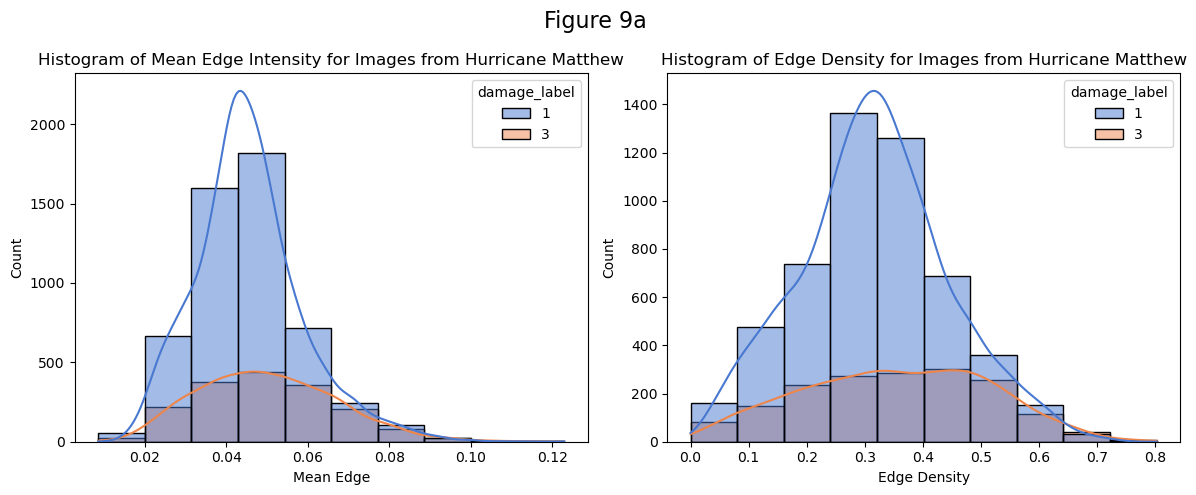

In [146]:
# Create histograms on subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for mean edge
sns.histplot(sobel_hurricane_df, x="mean_edge", hue="damage_label", bins=10, kde=True, ax=axes[0], palette="muted")
axes[0].set_title("Histogram of Mean Edge Intensity for Images from Hurricane Matthew")
axes[0].set_xlabel("Mean Edge")

# Histogram for edge density
sns.histplot(sobel_hurricane_df, x="edge_density", hue="damage_label", bins=10, kde=True, ax=axes[1], palette="muted")
axes[1].set_title("Histogram of Edge Density for Images from Hurricane Matthew")
axes[1].set_xlabel("Edge Density")

# Show plot and label
plt.suptitle("Figure 9a", fontsize=16)
plt.tight_layout()
plt.show()

In [147]:
sobel_data_df_corr = sobel_hurricane_df[["mean_edge", "edge_density", "damage_label"]]
sobel_data_df_corr.head()

,mean_edge,edge_density,damage_label
0,0.057136,0.399715,3
2,0.066945,0.499669,1
5,0.057615,0.393186,1
7,0.052025,0.378788,1
8,0.083214,0.604545,1


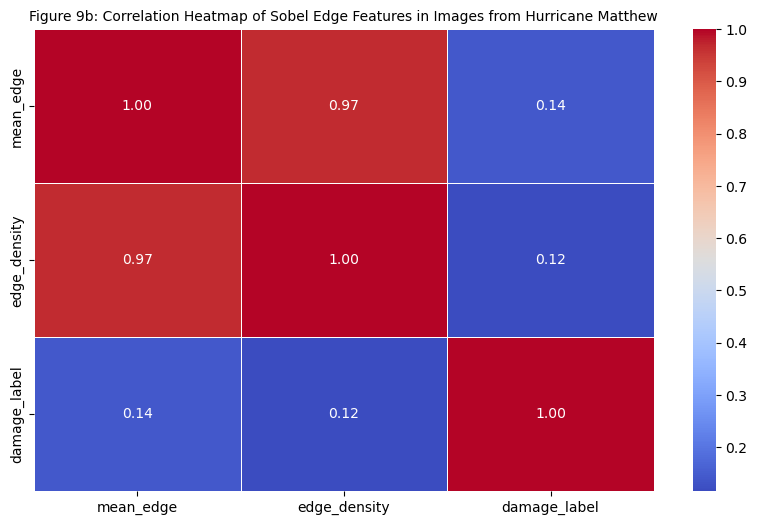

In [148]:
corr = sobel_data_df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 9b: Correlation Heatmap of Sobel Edge Features in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

Based on the above visualizations, there's little correlation between Sobel Edge mean density, edge density and damage label.

### Local Binary Patterns

In [149]:
hurricane_lbp_df = create_lbp_df(hurricane_images, hurricane_labels)
# filter out all damage labels except 1 and 3
hurricane_lbp_df = hurricane_lbp_df[~hurricane_lbp_df['damage_label'].isin([0, 2])] 
hurricane_lbp_df.head()

,damage_label,lbp_features,lbp_mean,lbp_std
0,3,"[[25.0, 25.0, 2.0, 5.0, 25.0, 25.0, 13.0, 25.0...",18.618803,9.261844
2,1,"[[6.0, 8.0, 10.0, 13.0, 25.0, 25.0, 25.0, 2.0,...",18.507275,9.241359
5,1,"[[7.0, 8.0, 25.0, 25.0, 25.0, 0.0, 1.0, 4.0, 8...",17.981612,9.588036
7,1,"[[25.0, 3.0, 0.0, 25.0, 5.0, 13.0, 10.0, 25.0,...",13.949495,9.227893
8,1,"[[0.0, 1.0, 2.0, 25.0, 25.0, 2.0, 3.0, 5.0, 6....",15.632273,9.188766


In [150]:
label1 = hurricane_lbp_df[hurricane_lbp_df['damage_label'] == 1]
label3 = hurricane_lbp_df[hurricane_lbp_df['damage_label'] == 3]

do_ttests(label1['lbp_mean'], label3['lbp_mean'], label1['lbp_std'], label3['lbp_std'])

Comparison of LBP Mean:
t-statistic = -34.113, p-value = 7.223e-210

Comparison of LBP Std:
t-statistic = -33.699, p-value = 3.834e-211


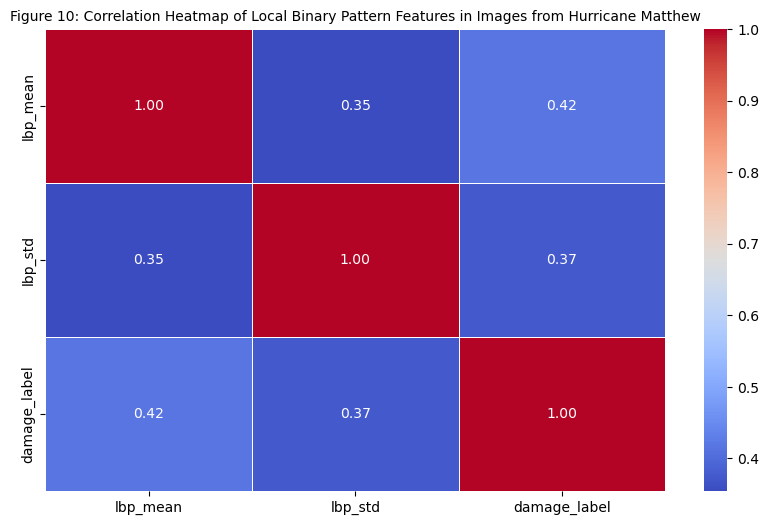

In [151]:
lbp_features = hurricane_lbp_df[['lbp_mean', 'lbp_std', 'damage_label']]
lbp_correlation_matrix = lbp_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(lbp_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 10: Correlation Heatmap of Local Binary Pattern Features in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

Based on the above visualizations, the label is correlated with the local binary pattern mean and standard deviation.

### Gabor Kernels

In [152]:
hurricane_gabor_df = create_gabor_df(hurricane_images, hurricane_labels)

# Filter out all damage labels except 1 and 3
hurricane_gabor_df = hurricane_gabor_df[~hurricane_gabor_df['damage_label'].isin([0, 2])] 

In [153]:
# Separate data into two groups based on label
label1 = hurricane_gabor_df[hurricane_gabor_df['damage_label'] == 1]
label3 = hurricane_gabor_df[hurricane_gabor_df['damage_label'] == 3]

do_ttests(label1['gabor_mean'], label3['gabor_mean'], label1['gabor_std'], label3['gabor_std'])

Comparison of LBP Mean:
t-statistic = 8.357, p-value = 1.023e-16

Comparison of LBP Std:
t-statistic = 19.968, p-value = 3.025e-83


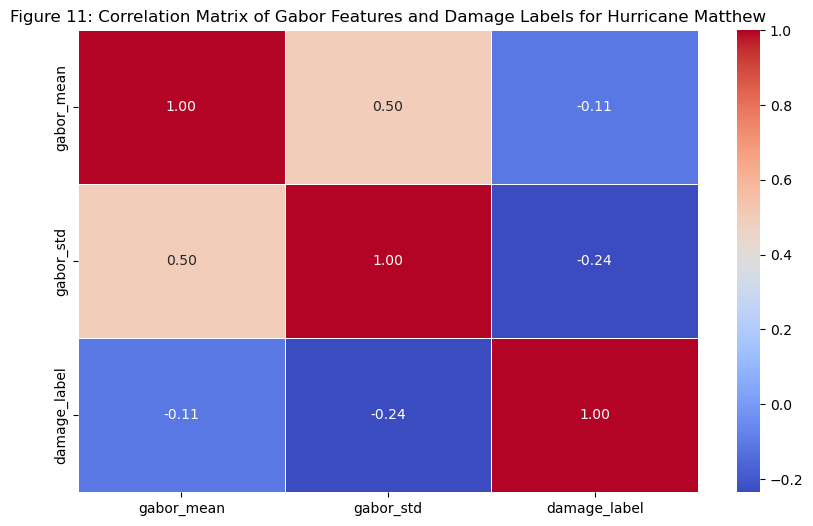

In [154]:
gabor_features = hurricane_gabor_df[['gabor_mean', 'gabor_std', 'damage_label']]
gabor_correlation_matrix = gabor_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gabor_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Figure 11: Correlation Matrix of Gabor Features and Damage Labels for Hurricane Matthew")
plt.show()

Based on the above correlation matrix, it appears that Gabor Kernel's standard deviation feature is correlated with damage label.